In [117]:
import pandas as pd
import tensorflow as tf 
import re 
import numpy
from tensorflow.python.client import device_lib
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Input)
from keras.models import Sequential
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Input)
from keras.callbacks import EarlyStopping



[nltk_data] Downloading package stopwords to C:\Users\Kiril
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:

#Version de Tensorflow
tf.__version__

'2.6.0'

In [73]:
#Dispositivos disponibles para entrenar la NN
print("El estado de la GPU es :" ,tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))
print("--------Disponemos de los siguientes dispositivos----------")
print(device_lib.list_local_devices())

El estado de la GPU es : False
--------Disponemos de los siguientes dispositivos----------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8969776823260258892
]


In [74]:
#Carga del dataset
df = pd.read_csv('D:\[3]--Python Workdir--[3]\Data - ML- DL- projects\datasets\googleplaystore_user_reviews.csv')
df.head(3)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN


In [75]:
#Suprimimos los nulls
df.dropna(inplace=True)

In [76]:
#comprobamos
df.isnull().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

In [77]:
df.shape

(37427, 5)

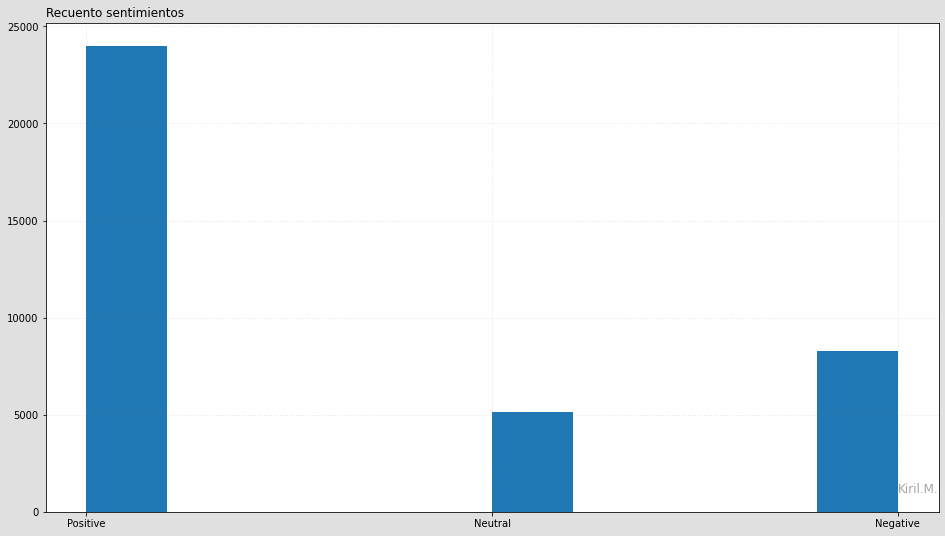

In [78]:

#Distribución valoraciones
fig, ax = plt.subplots(figsize=(16, 9),facecolor='#E0E0E0', edgecolor='#9EC8B2') 
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.hist(df["Sentiment"])
ax.set_title('Recuento sentimientos',
             loc ='left')
             # Add Text watermark
fig.text(0.9, 0.15, 'Kiril.M.', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

In [79]:
df = df[["Translated_Review","Sentiment"]]

In [80]:
def preprocess_text(sen):
    # Eliminar símbolos de puntuación y números
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Eliminar carácteres sueltos
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Eliminar espacios excesivos
    sentence = re.sub(r'\s+', ' ', sentence)

    # Convertir a minúscula
    sentence = sentence.lower()
  
    # Eliminar las stopwords.
    words = sentence.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(filtered_words)

In [81]:
df['Translated_Review'] = df['Translated_Review'].apply(lambda sen: preprocess_text(sen))
df.head(3)

,Translated_Review,Sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,works great especially going grocery store,Positive


In [82]:
def determine_class(label):
  if label == 'Positive':
    return 0
  elif label == 'Neutral':
    return 1
  elif label == 'Negative':
    return 2

In [83]:
df_train = df['Sentiment'].apply(lambda x: determine_class(x)).to_numpy()

In [86]:
X = df['Translated_Review']
y = df_train.astype(numpy.uint8)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [92]:
NUMBER_OF_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [93]:
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

In [94]:
VOCABULARY_SIZE = NUMBER_OF_WORDS
EMBEDDING_SIZE = 128

In [112]:
def keras_model(learning_rate):
 
    model = Sequential()
    model.add(tf.keras.layers.Embedding(VOCABULARY_SIZE, 
                                    EMBEDDING_SIZE, 
                                    input_shape=(X_train.shape[1],)))

    model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))
    model.add(tf.keras.layers.Dense(6, activation='relu'))

    #En units, se debe especificar cuantas clases tenemos. 
    model.add(tf.keras.layers.Dense(units=numpy.unique(y_train).shape[0], 
                                activation='sigmoid'))

    ###### Compilar el Modelo #######
    model.compile(optimizer='rmsprop', 
                loss='sparse_categorical_crossentropy', 
                metrics=['sparse_categorical_accuracy'])
    return model

In [113]:
model = keras_model(0.01)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
Total params: 2,692,379
Trainable params: 2,692,379
Non-trainable params: 0
_________________________________________________________________


In [121]:
callback = EarlyStopping(monitor='loss', patience=3)
epochs=3
historia  = model.fit(X_train, y_train, epochs=epochs, batch_size=128, callbacks=[callback])

Epoch 1/3
234/234 [==============================] - 37s 160ms/step - loss: 0.8915 - sparse_categorical_accuracy: 0.6421
Epoch 2/3
234/234 [==============================] - 38s 163ms/step - loss: 0.8903 - sparse_categorical_accuracy: 0.6423
Epoch 3/3
234/234 [==============================] - 38s 163ms/step - loss: 0.8900 - sparse_categorical_accuracy: 0.6430


In [123]:
test_loss, test_acurracy = model.evaluate(X_test, y_test)
print("Test accuracy: {}".format(test_acurracy))

234/234 [==============================] - 2s 11ms/step - loss: 0.8952 - sparse_categorical_accuracy: 0.6392
Test accuracy: 0.6391931772232056


In [126]:
print(historia.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy'])


ipykernel_launcher:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
ipykernel_launcher:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


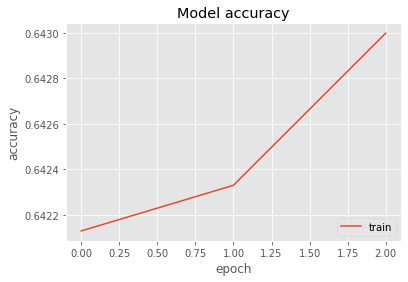

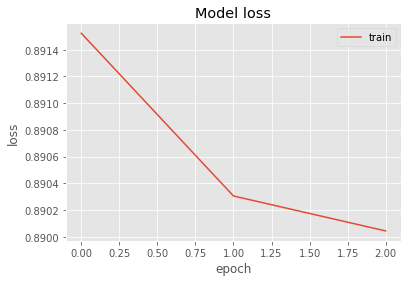

In [129]:
plt.style.use('ggplot')

fig, ax = plt.subplots()
ax.plot(historia.history['sparse_categorical_accuracy'])
ax.set_title('Model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='lower right')
fig.show()

fig, ax = plt.subplots()
ax.plot(historia.history['loss'])
ax.set_title('Model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
fig.show()